In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import seaborn as sbn

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import gensim
from gensim.models import Word2Vec

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report

#### Loading in data

In [ ]:
drive.mount("/content/drive")
filepath = "/content/drive/MyDrive/CMPE257/project/"

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv(filepath+ "train.csv")
test_df = pd.read_csv(filepath + "test.csv")
print(train_df.shape)
print(test_df.shape)

(7613, 5)
(3263, 4)


#### Viewing data information

In [ ]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df.drop(columns=["id"], inplace=True)
kaggle_data = pd.DataFrame(test_df["id"])
test_df.drop(columns=["id"], inplace=True)

In [ ]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

keyword       61
location    2533
text           0
target         0
dtype: int64
keyword       26
location    1105
text           0
dtype: int64


#### Data cleaning

In [ ]:
# removing URLs and emojis and keep US alphabet and white spaces (i.e. remove numbers and other non alpabetic characters)
regex_dont_remove = "[^A-Za-z\s]"
regex_remove = "(\w+)://([\w\-\.]+)/(\w+).(\w+)|[\U00010000-\U0010ffff]"
train_df["text"] = train_df["text"].str.replace(r"" + regex_remove + "|" + regex_dont_remove,"")
test_df["text"] = test_df["text"].str.replace(r"" + regex_remove + "|" + regex_dont_remove,"")

In [ ]:
# conversion to lowercase and lemmatization using nltk
nltk.download("punkt")
nltk.download("wordnet")
lemmatizer = WordNetLemmatizer()
def lemmatize(sentence):
    tokens = [lemmatizer.lemmatize(w.lower()) for w in word_tokenize(sentence)]
    return " ".join(tokens)

train_df["text"] = train_df["text"].apply(lemmatize)
test_df["text"] = test_df["text"].apply(lemmatize)

print(train_df.head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
  keyword location                                               text  target
0     NaN      NaN  our deed are the reason of this earthquake may...       1
1     NaN      NaN              forest fire near la ronge sask canada       1
2     NaN      NaN  all resident asked to shelter in place are bei...       1
3     NaN      NaN  people receive wildfire evacuation order in ca...       1
4     NaN      NaN  just got sent this photo from ruby alaska a sm...       1


#### Playing with word2vec and word_tokenize (Not sure where to go with this yet)

In [ ]:
# train_df["text"] = train_df["text"].apply(word_tokenize)
# model = gensim.models.Word2Vec(train_df["text"])

#### Text feature extractions using sklearn's CountVectorizer & TfidfTransformer

In [ ]:
# Leaving the NaN for keywords and location features

# using the strip accent and stop word removal provided by sklearn's CountVectorizer
# I needed to limit the max_features to work with the training dataset
countVec = CountVectorizer(strip_accents="unicode", stop_words="english", max_features=9250)
train_countVec = countVec.fit_transform(train_df["text"])
test_countVec = countVec.fit_transform(test_df["text"])
print(train_countVec.shape)
print(test_countVec.shape)

tfidf = TfidfTransformer()
train_tfidf = tfidf.fit_transform(train_countVec)
test_tfidf = tfidf.fit_transform(test_countVec)
print(train_tfidf.shape)
print(test_tfidf.shape)

(7613, 9250)
(3263, 9250)
(7613, 9250)
(3263, 9250)


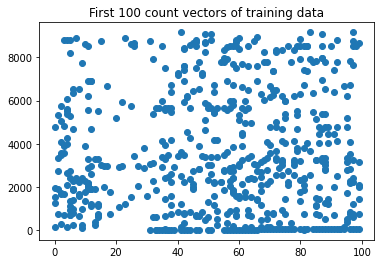

In [ ]:
coo_mat = coo_matrix(train_countVec[:100])
plt.scatter(coo_mat.row, coo_mat.col)
plt.title("First 100 count vectors of training data")
plt.show()

#### Splitting train.csv into training & testing subsets

In [ ]:
train_percent = 0.7
split_index = round(train_countVec.shape[0]*train_percent)

x_train_countVec = train_countVec[:split_index]
x_train_tfidf = train_tfidf[:split_index]
y_train = train_df.iloc[:split_index, -1]
print(x_train_tfidf.shape, x_train_countVec.shape, y_train.shape)

x_test_countVec = train_countVec[split_index:]
x_test_tfidf = train_tfidf[split_index:]
y_test = train_df.iloc[split_index:, -1]
print(x_test_tfidf.shape, x_test_countVec.shape, y_test.shape)

(5329, 9250) (5329, 9250) (5329,)
(2284, 9250) (2284, 9250) (2284,)


#### Building and evaluating sklearn's RandomForestClassifier

Evaluation score using only count vectorization: 0.7088441330998249 Training time (s): 5.1151745319366455
              precision    recall  f1-score   support

           0       0.67      0.94      0.78      1275
           1       0.84      0.42      0.56      1009

    accuracy                           0.71      2284
   macro avg       0.76      0.68      0.67      2284
weighted avg       0.75      0.71      0.68      2284



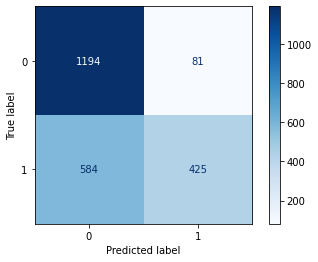

In [ ]:
rfclf = RandomForestClassifier(criterion="gini", max_depth=100, n_jobs=8)
Tbegin = time.time()
rfclf.fit(x_train_countVec, y_train)
Tend = time.time()
print("Evaluation score using only count vectorization:", rfclf.score(x_test_countVec, y_test), "Training time (s):", Tend-Tbegin)
print(classification_report(y_test, rfclf.predict(x_test_countVec)))
plot_confusion_matrix(rfclf, x_test_countVec, y_test, cmap="Blues", values_format='d')

Evaluation score using tf-idf: 0.7040280210157618 Training time (s): 4.5830605030059814
              precision    recall  f1-score   support

           0       0.67      0.94      0.78      1275
           1       0.85      0.40      0.55      1009

    accuracy                           0.70      2284
   macro avg       0.76      0.67      0.66      2284
weighted avg       0.75      0.70      0.68      2284



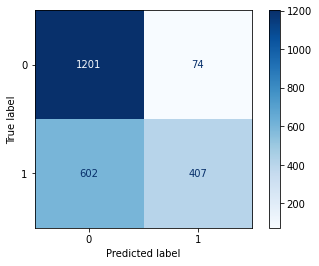

In [ ]:
rfclf = RandomForestClassifier(criterion="gini", max_depth=100, n_jobs=8)
Tbegin = time.time()
rfclf.fit(x_train_tfidf, y_train)
Tend = time.time()
print("Evaluation score using tf-idf:", rfclf.score(x_test_tfidf, y_test), "Training time (s):", Tend-Tbegin)
print(classification_report(y_test, rfclf.predict(x_test_tfidf)))
plot_confusion_matrix(rfclf, x_test_tfidf, y_test, cmap="Blues", values_format='d')

In [ ]:
rfclf = RandomForestClassifier(criterion="gini", max_depth=100, n_jobs=8)
rfclf.fit(train_countVec, train_df["target"])
y_predict = rfclf.predict(test_countVec)
kaggle_data["target"] = y_predict
kaggle_data.to_csv(filepath + "nlp_disaster_tweets_kaggle_prediction.csv", index=False)

In [ ]:
print("Frequency of no disaster predictions", kaggle_data[kaggle_data["target"] == 0].count()[1])
print("Frequency of disaster predictions", kaggle_data[kaggle_data["target"] == 1].count()[1])

Frequency of no disaster predictions 3128
Frequency of disaster predictions 135
